In [1]:
import pandas as pd
import requests
import operator
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.dates as mdates

%matplotlib inline
plt.style.use("ggplot")

In [2]:
# Base settings
TOKEN = "INSERT_YOUR_TOKEN_HERE"
LANGUAGES = ["java", "ruby", "php", "javascript", "python"]

O código fonte utilizado está minimizado no bloco abaixo.

In [3]:
class Dataset:
    def __init__(self, token="", languages=[]):
        self.token = token
        self.languages = languages

        
    def graphql(self, data, variables={}):
        results = requests.post("https://api.github.com/graphql",  json={'query': data, 'variables': variables},
                          headers={"Authorization": "Bearer %s" % self.token})
        return results.json()


    def fetchTopProjects(self, language_name, limit=50):
        topProjectsQuery = """
        query TopProjects($search: String!) {
          search(first: 100, query: $search, type: REPOSITORY) {
            edges {
              node {
                ... on Repository {
                  name
                  createdAt
                  description
                  owner {
                    login
                  }
                  stargazers {
                    totalCount
                  }
                  defaultBranchRef {
                    name
                    target {
                      ...on Commit {
                        history(first: 0) {
                          totalCount
                        }
                      }
                    }
                  }
                }
              }
            }
          }
        }
        """

        # If data is cached, return directly
        cacheName = "data/projects_%s.csv" % language_name    
        projects_file = Path(cacheName)
        if projects_file.is_file():
            data = pd.read_csv(cacheName)
            if data.shape[0] > 0:
                return data

        results = self.graphql(topProjectsQuery, {"search": "language:%s" % language_name})
        projects = results.get("data").get("search").get("edges")

        values = [{
            "language": language_name,
            "name": project.get("node").get("name"),
            "owner": project.get("node").get("owner").get("login"),
            "description": project.get("node").get("description") or "",
            "createdAt": project.get("node").get("createdAt"),
            "defaultBranch": project.get("node").get("defaultBranchRef").get("name"),
            "stars": project.get("node").get("stargazers").get("totalCount"),
            "commits": project.get("node").get("defaultBranchRef").get("target").get("history").get("totalCount")
        } for project in projects]

        dataFrame = pd.DataFrame(values, columns=["language", "name","owner", "description", "createdAt", "defaultBranch", "stars", "commits"])
        dataFrame['stars'] = dataFrame['stars'].astype('int')
        dataFrame['commits'] = dataFrame['commits'].astype('int')

        # Removing invalid projects
        dataFrame = dataFrame[~dataFrame['name'].str.contains("book|awesome|pattern|tutorial|codebase")]
        dataFrame = dataFrame[~dataFrame['description'].str.contains("book|awesome|pattern|tutorial|codebase")]
        dataFrame = dataFrame.head(limit)

        # Save data in local cache
        dataFrame.to_csv(cacheName, index=False)

        return dataFrame


    def fetchContributitors(self, owner, project_name):
        # If data is cached, return directly
        cacheName = "data/top_contributors_%s_%s.csv" % (owner, project_name)    
        projects_file = Path(cacheName)
        if projects_file.is_file():
            data = pd.read_csv(cacheName)
            if data.shape[0] > 0:
                return data

        results = requests.get("https://api.github.com/repos/%s/%s/contributors?anon=1" % (owner, project_name),
                               headers={"Authorization": "token %s" % self.token})

        if results.status_code != requests.codes.ok:
            print("fail to fetch contributors from %s/%s." % (owner, project_name))

        values = [{
            "login": result.get("login") or result.get("email") or result.get("name"),
            "commits": int(result.get("contributions"))
        } for result in results.json()]

        dataFrame = pd.DataFrame(values, columns=["login", "commits"])
        dataFrame['commits'] = dataFrame['commits'].astype('int')
        dataFrame.sort_values(by=["commits"], ascending=False, inplace=True)

        # Save data in local cache
        dataFrame.to_csv(cacheName, index=False)

        return dataFrame


    def getCoreDeveloper(self, developers, commitsCount):
        totalPercent = 0.0
        coreDevelopers = []

        # Sort developers by commits
        developers = pd.DataFrame(developers).sort_values(by=["commits"], ascending=False)

        for _, developer in developers.iterrows():
            percent = developer.get("commits") / commitsCount
            if totalPercent < 0.8 and percent > 0.05:
                totalPercent += percent
                coreDevelopers.append(developer)

        return coreDevelopers
    
    def getProjects(self):
        allProjects = pd.DataFrame(columns=["language", "name", "owner", "description", "createdAt", "defaultBranch", "stars", "commits"])
        allProjects['stars'] = allProjects['stars'].astype('int')
        allProjects['commits'] = allProjects['commits'].astype('int')

        for language in self.languages:
            result = pd.DataFrame(dataset.fetchTopProjects(language))
            allProjects = allProjects.append(result).drop_duplicates().reset_index(drop=True)
        
        return allProjects
    
    def getContributorsProjects(self, projects):
        relationship = pd.DataFrame(columns=["project", "login"])
        
        for _, project in projects.iterrows():
            projectSlug = "{0}/{1}".format(project.get("owner"),  project.get("name"))
            contributors = self.fetchContributitors(project.get("owner"), project.get("name"))
            coreDevelopers = self.getCoreDeveloper(pd.DataFrame(contributors), project.get("commits"))

            for developer in coreDevelopers:
                data = {"project": projectSlug, "login": developer.get("login")}
                relationship = relationship.append(data, ignore_index=True)
                
        return relationship

# **Análise de Core Developers - Github**
### **Manutenção e Evolução de Software - PPGCC - UFMG**
Marco Túlio Oliveira Valente<br>
Rodrigo Ferreira de Brito<br>
<br>

O presente trabalho consiste em identificar e analisar os *core developers* dos principais projetos presentes no GitHub das linguagens Java, Ruby, PHP, JavaScript e Python. *Core developers* são caracterizados como os principais mantenedores do projeto, que contribuem ativamente e são autores das maiores parcelas de código dos sistemas.

Para cada usuário, foram contabilizados os commits efetuados no principal branch do projeto. Sendo definido como core contributor, aqueles que possuem autoria de mais de 5% do código e fazem parte dos grupo que detém 80% das maiores contribuições registradas no projeto <a href="#ref1">[1]</a>.

Para evitar a análise de repositórios que não possúem sistemas válidos, como livros, *awesome-lists* e repositórios com exemplos de implementação, foram desconsiderados os registros que possuem os termos: *book*, *pattern*, *tutorial*, *awesome* e *codebase* no nome ou em sua descrição. Mantendo um total de 50 projetos para cada linguagem analisada.

A análise foi feita utilizando as biliotecas Pandas para gerência e busca em *Data Frames* e Matplotlib para representação visual por meio de gráficos. Os dados foram obtidos por meio da API do Github <a href="#ref2">[2]</a> e filtrados por meio da linguagem Python.

O gráfico abaixo mostra a distribuição de dos 250 projetos analisados, a base utilizada é bastante diversificada, contendo projetos uma média vinte mil estrelas e sete mil *commits*. No entando, existema alguns projetos que ultrapassam a marca cem mil *commits* e estrelas.

In [4]:
dataset = Dataset(token=TOKEN, languages=LANGUAGES)
allProjects = dataset.getProjects()
allProjects.describe()

,stars,commits
count,250.000000,250.000000
mean,20378.364000,7672.532000
std,15713.275828,14218.909799
min,5814.000000,1.000000
25%,9809.750000,843.000000
50%,14462.500000,2207.500000
75%,28194.250000,7623.750000
max,111969.000000,102091.000000


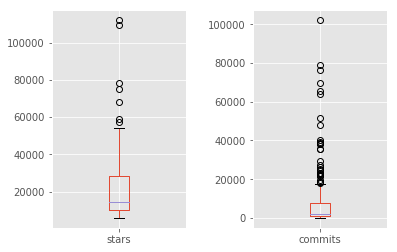

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.5)
allProjects["stars"].plot.box(ax=axes[0])
allProjects["commits"].plot.box(ax=axes[1])
plt.show()

#### **1. Qual o tamanho do conjunto de core developers dos sistemas analisados? Qual o sistema que tem o maior número de core developers?**

Os projetos com maior número de *core developers* são *SeleniumHQ/selenium, meteor/meteor e adobe/brackets*, contabilizando um total de 7 mantenedores cada. No total foram identifcados 697 *code developers*.


In [17]:
developerProject = dataset.getContributorsProjects(allProjects)
developersByProject = developerProject.groupby(["project"]).count().sort_values(by=["login"], ascending=False)
developersByProject = developersByProject.rename(columns={"login": "Núm. Usuários"})
developersByProject.index.names = ['Projeto']
print("Total = %d desenvolvedores" % developersByProject.sum())
developersByProject.head(5)

Total = 697 desenvolvedores


,Núm. Usuários
Projeto,
adobe/brackets,7
meteor/meteor,7
SeleniumHQ/selenium,7
discourse/discourse,6
keon/algorithms,6


No entanto, grande parte dos projetos possuem entre 2 e 4 desenvolvedores responsáveis pela gerência e manutenção. O Gráfico abaixo mostra a distribuição de core developers registrados.

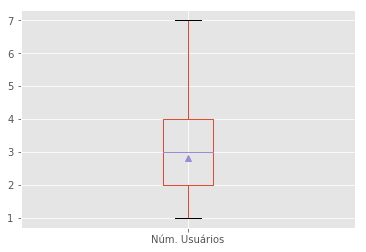

In [7]:
developersByProject.boxplot(showmeans=True)
plt.show()

Além disso, cerca de 55 projetos possuem apenas 1 *core developer* detentor de mais de 80% das contribuições registradas.

In [8]:
developersByProject[developersByProject["Núm. Usuários"] == 1].count()

Núm. Usuários    55
dtype: int64

#### **2. Existem core developers que são bots? Se sim, o que esses bots fazem?**

In [9]:
developerProject[developerProject['login'].str.contains("bot") & ~developerProject['project'].str.contains("greenrobot|thoughtbot")]

,project,login
19,google/guava,guava.mirrorbot@gmail.com@8138a162-5c33-11de-8...
145,jekyll/jekyll,jekyllbot
173,ruby/ruby,matzbot
521,zeit/next.js,greenkeeper[bot]
625,Valloric/YouCompleteMe,zzbot
648,wangshub/wechat_jump_game,wangsong@lejurobot.com


Através de uma busca com o termo "bot" na lista de usuários registrados, foi possível identificar alguns perfis de robôs atuando em repositórios analisados. Os *bots* geralmente são gerenciados por algum sistema de integração contínua e acionados por eventos específicos, como fechamentos de Pull Requests ou submissão de *releases* de aplicação.

No projeto google/guava, o robô identificado era responsável por sincronizar o repositório com outras fontes de contribuição, o robô é gerenciado por um projeto do Google chamado *Make Opensource Easy* (MOE), um robô específico para espelhamento de repositórios. Semelhante ao zzbot do projeto YouCompleteMe que é utilizado para integrar as novas contribuições no repositório. 

No projecto Jekyll, o robô é responsável por atualizar o arquivo de histórico de mudanças toda vez que um Pull Request é aceito. Já o Ruby utiliza o *matzbot* para incrementar uma constante que identifica a data do último *release* registrado.

O Projecto Next.js utilizava um bot chamado Greenkeeper, atualmente desativado no projeto. O robô era responsável por identificar dependências desatualizadas e sugerir novas atualizações.

#### **3. Como o tamanho deste conjunto varia por linguagem?**

O gráfico abaixo apresenta a distribuição de *core developers* por linguagem analisada. Projetos Javascript, Python e Ruby possuem comportamentos semelhantes, obtendo um registro de 2 a 4 desenvolvedores na maioria dos projetos analisados. 

No entanto, projetos Java apresentaram uma distribuição mais ampla, variando entre 1 e 4 desenvolvedores, com alguns casos especiais que chegaram a registrar 7 *core developers*.

Projetos PHP registraram uma variação dominante de 2 a 4 desenvolvedores, possuindo um caso especial que obteve a marca de 6 mantenedores.

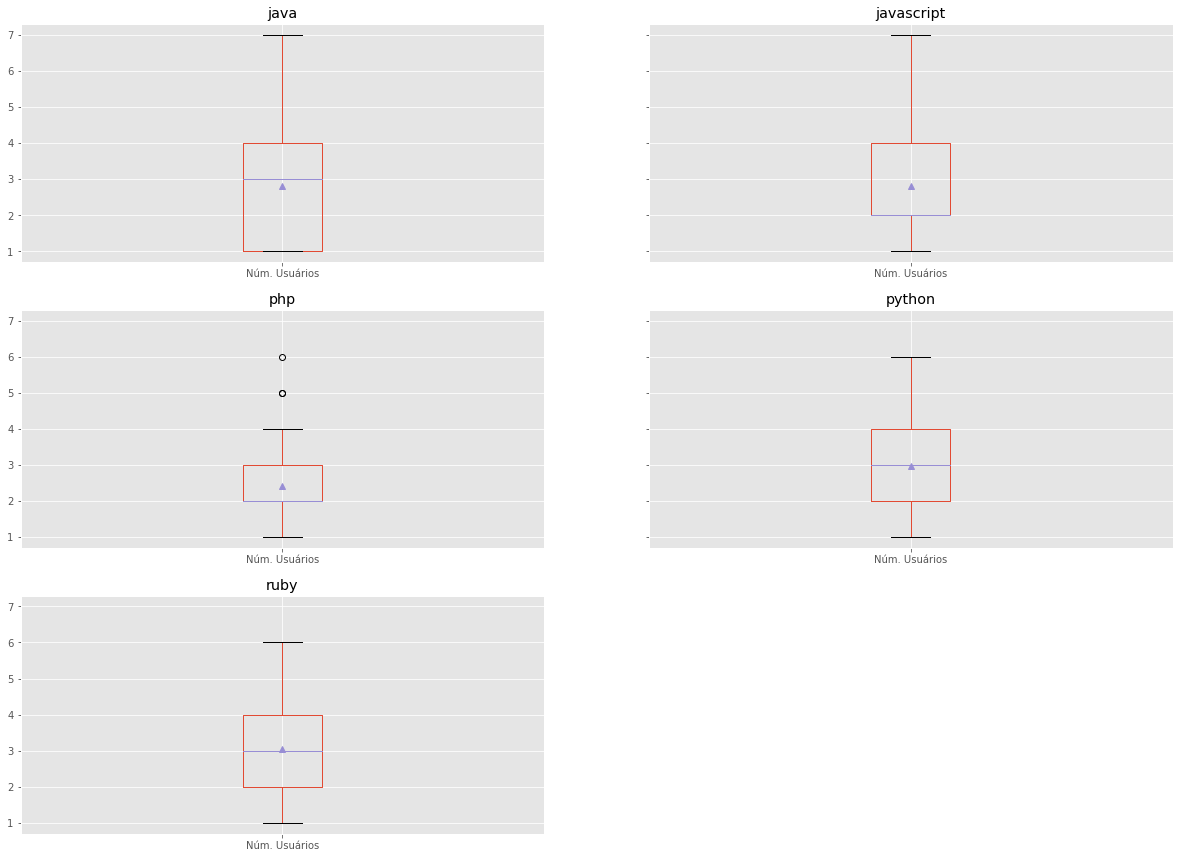

In [18]:
developersByProject = developersByProject.reset_index()
allProjects["Projeto"] = allProjects.apply(lambda row: "%s/%s"  % (row["owner"], row["name"]) ,axis=1)
developersByLanguage = developersByProject.join(allProjects.set_index("Projeto"), on="Projeto")
developersByLanguage[["Núm. Usuários", "language"]].groupby("language").boxplot(figsize=(20,15), showmeans=True)
plt.show()

#### **4. Como o tamanho deste conjunto varia por idade dos sistemas?**

O número de mantenedores em função da idade dos projetos não apresentaram grandes diferenças. Segmentando todos os projetos em faixas de idades é possível notar que projetos de até 6 anos apresentam um comportamento aproximado, com um registro médio de 2,6 core developers por projeto. Já os sistemas mais antigos, com mais de 6 anos, registraram uma média próxima de 3 mantenedores por projeto.

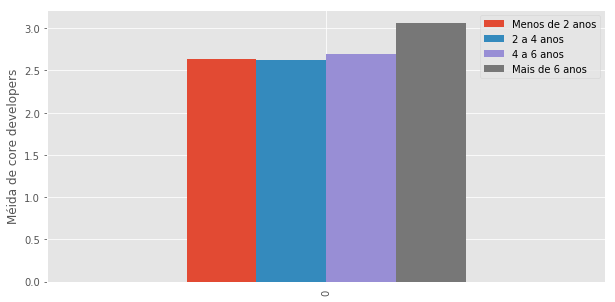

In [11]:
usersByTime = developersByLanguage[["createdAt", "Núm. Usuários"]].sort_values(by=["createdAt"], ascending=True)
plot = {
    "Menos de 2 anos": usersByTime[usersByTime["createdAt"] > "2016-01-01"]["Núm. Usuários"].mean(),
    "2 a 4 anos": usersByTime[(usersByTime["createdAt"] < "2016-01-01") & (usersByTime["createdAt"] > "2014-01-01")]["Núm. Usuários"].mean(),
    "4 a 6 anos": usersByTime[(usersByTime["createdAt"] <= "2014-01-01") & (usersByTime["createdAt"] > "2012-01-01")]["Núm. Usuários"].mean(),
    "Mais de 6 anos": usersByTime[usersByTime["createdAt"] <= "2012-01-01"]["Núm. Usuários"].mean()
}
ax = pd.DataFrame(plot,index=[0]).plot.bar(figsize=(10,5))
ax.set_ylabel("Méida de core developers")
ax.xaxis.set_ticks_position('none')
plt.show()

#### **5. De quantos projetos os desenvolvedores analisados são core developers?**

O gráfico abaixo apresenta a comparação entre os desenvolvedores que são contribuidores principais em apenas 1 projeto e aqueles que foram identificados como mantenedores em mais de um projeto.

É possível notar que mais de 94% dos desenvolvedores são mantenedores de apenas um único projeto. Enquanto um pequena minoria, apenas 6%, divide o tempo de dedicação em projetos paralelos.

Apenas 1 repositório 94.1%


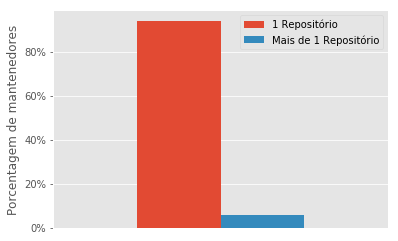

In [12]:
userByProject = developerProject.groupby(["login"]).count().sort_values(by=["project"], ascending=False)
totalProjects = userByProject.count()
plot = {
    "1 Repositório": userByProject[userByProject["project"] == 1].count() / totalProjects,
    "Mais de 1 Repositório": userByProject[userByProject["project"] > 1].count() / totalProjects
}
print("Apenas 1 repositório %.1f%%" % (plot.get("1 Repositório") * 100))
ax = pd.DataFrame(plot).plot.bar()
ax.set_ylabel("Porcentagem de mantenedores")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xticks([])
plt.show()

Alguns casos especiais, como o do desenvolvedor Jake Wharton que é *core developer* em 6 projetos analisados, sendo que grande parte é da mesma organização, Square. Square que detém grandes projetos Android, tais como Retrofit, Picasso e OkHTTP, onde Jake é um dos principais desenvolvedores.

In [13]:
userByProject.head(5)

,project
login,
JakeWharton,6
fabpot,4
benjchristensen,3
GrahamCampbell,3
swankjesse,3


#### **6. Como o tamanho deste conjunto varia com o número de commits de um sistema?**


O gráfico abaixo apresenta uma simples comparação entre projetos com apenas 1 mantenedor e os demais. É possível notar que projetos com mais de um mantenedor tendem a ter mais commits. Onde os projetos com apenas 1 desenvolvedor obtiveram média abaixo de 2000 commits por projeto, enquanto os demais apresentaram média maior que 8000 commits. 

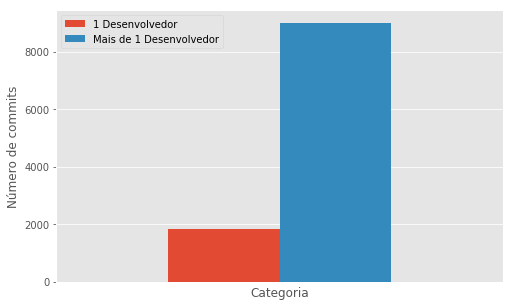

In [14]:
result = developersByLanguage[["commits", "Núm. Usuários"]]
plot = {
    "1 Desenvolvedor": result[result["Núm. Usuários"] == 1]["commits"].mean(),
    "Mais de 1 Desenvolvedor": result[result["Núm. Usuários"] > 1]["commits"].mean()
}
ax = pd.DataFrame(plot,index=[0]).plot.bar(figsize=(8,5))
ax.set_ylabel("Número de commits")
ax.set_xlabel("Categoria")
ax.xaxis.set_ticks_position('none')
plt.xticks([])
plt.show()

### **Ameaças à validação**

A presente seção apresenta possíveis fatores que podem influenciar nos resultados do trabalho. Apesar da coleta de dados ser próxima da análise, novos desenvolvedores podem entrar na categoria de mantenedores e alterar parcialmente os resultados reportados, assim como novos projetos entrarem no *rank* de busca do Github.

A lista dos principais projetos incluem sistemas descontinuados que não recebem mais contribuições ou estão no fim de sua vida últil, podendo impactar análises temporais, uma vez que o tempo de vida foi estagnado.

Os desenvolvedores foram identificados pelo login do Github, porém um mesmo desenvolvedor pode utilizar diferentes credenciais e até mesmo submeter contribuições de forma anônima utilizando diferentes emails. O Github valida o usuário na submissão via Pull Request, porém o histórico enviado diretamente pelo mantenedor pode utilizar email de outras pessoas, gerando falsas contabilizações de contribuição. Um exemplo pode ser visto abaixo, onde o mantenedor possuí diferentes emails e todas as contribuições foram feitas de forma anônima para [DrKLO/Telegram](https://github.com/DrKLO/Telegram/graphs/contributors).

In [15]:
dataset.fetchContributitors(owner="DrKLO", project_name="Telegram").head()

,login,commits
0,drklo.2kb@gmail.com,294
1,drklo@imac-nikolay.local,6
2,jsonchi,2
3,astarcev@workle.ru,1
4,zhukov,1


### **Conclusões**

O presente trabalho objetivou analisar os principais projetos do Github, buscando identificar os *core developers* e suas principais características em projetos Open Source. Diante disso, foram coletados dados de 250 projetos de 5 linguagens de programação.

As análises mostraram que grande parte dos projetos são mantidos por poucos desenvolvedores, em grande parte dos casos por um único mantenedor, principalmente em projetos PHP. Também foi reportado que projetos com apenas 1 *core developer*, a média de commits é significamente menor.

Também foram identificados alguns casos de desenvolvedores mantenedores em múltiplos projetos, chegando a marca de 6 projetos simultâneos em um dos casos analisados. No entanto mais de 94% dos desenvolvedores são responsáveis por um único projeto.

### **Referências**

<span id="ref1">[1]</span> **Jailton Coelho, Marco Tulio Valente, Luciana L. Silva, Andre Hora.** Why We Engage in FLOSS: Answers from Core Developers. In 11th International Workshop on Cooperative and Human Aspects of Software Engineering (CHASE), páginas 14-21, 2018.

<span id="ref2">[2]</span> **Github**. GraphQL API V4. 20 Agosto 2018. Disponível em: https://developer.github.com/v4.